In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from HPA_CC.models.train import find_checkpoint_file, PseudoRegressorLit, ClassifierLit, CombinedModelLit
from HPA_CC.models.utils import regressor_inference, classifier_inference, combined_inference
from HPA_CC.data.data_viz import save_image, annotate_cell_image
from HPA_CC.utils.img_tools import get_batch_percentiles
from HPA_CC.data.well_normalization import buckets
from HPA_CC.utils.pseudotime import stretch_time
from HPA_CC.data.dataset import RefCLSDM

from config import HOME, HPA_DS_PATH, FUCCI_DS_PATH
classes = ["M-G1", "G1", "S-G2", "G2"]
protein = "CCNB1"
data_name = "minimal"

/tmp/ipykernel_442935/952751461.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(HOME / 'data' / 'ifimages_v23.csv')
print(df.columns)
df.head()

Index(['filename', 'jpg_prefix', 'if_plate_id', 'position', 'sample', 'status',
       'Image status name', 'locations', 'staining characteristics',
       'unspecific', 'antibody', 'ensembl_ids', 'gene_names', 'atlas_name',
       'versions', 'earliest_version', 'first_released', 'latest_version',
       'Spatial cell cycle', 'Intensity cell cycle', 'Annotated cell cycle',
       'gain', 'x_pos', 'y_pos', 'z_pos', 'Experiment state', 'Ab state',
       'Max tpm', 'Finished in genes', 'Protocol',
       'Gene reliability (in release)', 'Gene reliability (lims)',
       'Cell count', 'well_location_predictions_all'],
      dtype='object')


,filename,jpg_prefix,if_plate_id,position,sample,status,Image status name,locations,staining characteristics,unspecific,...,z_pos,Experiment state,Ab state,Max tpm,Finished in genes,Protocol,Gene reliability (in release),Gene reliability (lims),Cell count,well_location_predictions_all
0,/archive/1/1_A1_1_,https://lims.proteinatlas.org/images/992/1_A1_1_,1,A1,1,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,7.0,NaN
1,/archive/1/1_A1_2_,https://lims.proteinatlas.org/images/992/1_A1_2_,1,A1,2,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,6.0,NaN
2,/archive/1/1_A3_1_,https://lims.proteinatlas.org/images/2899/1_A3_1_,1,A3,1,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,4.0,NaN
3,/archive/1/1_A3_2_,https://lims.proteinatlas.org/images/2899/1_A3_2_,1,A3,2,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,6.0,NaN
4,/archive/1/1_A6_1_,https://lims.proteinatlas.org/images/609/1_A6_1_,1,A6,1,35,Annotated / Proteinatlas,"Endoplasmic reticulum,Nuclear membrane",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,81.38,ENSG00000102119,PFA,Enhanced,Enhanced,5.0,NaN


In [3]:
print(df[["filename", "antibody", "gene_names"]].values[0])

['/archive/1/1_A1_1_' 'HPA000992' 'GOLGA5']


In [4]:
def prefix_to_well(filename):
    image_id = filename.split('/')[-1]
    return '_'.join(image_id.split('_')[:2])

df["well"] = df["filename"].apply(prefix_to_well)
print(df["well"].values)

['1_A1' '1_A1' '1_A3' ... '2172_F7' '2172_H8' '2172_H8']


In [5]:
CCD_prots = ["DUSP19", "DUSP18", "PAPSS1", "N6AMT1", "PHLDB1", "FLI1", "TTC21B", "PC", "UGDH", 
             "ORC6", "ZNF32", "CCNE1", "CCNB1", "AURKB", "BUB1B", "DPH2", "GMNN", "CDT1", "ANLN"]
ccd_rows = df["gene_names"].isin(CCD_prots) & df["atlas_name"].isin(["U2OS"])
ccd_df = df[ccd_rows]
print(ccd_df["filename"].values[0])
print(ccd_df[["well", "antibody", "gene_names"]].values[0])

/archive/91/91_H6_1_
['91_H6' 'HPA008419' 'BUB1B']


# Setup and Data Prep

In [6]:
# Pick a protein
DS_HOME = HPA_DS_PATH
# DS_HOME = FUCCI_DS_PATH
prot_well_names = ccd_df[ccd_df["gene_names"] == protein]["well"].unique()
prot_abs = ccd_df[ccd_df["gene_names"] == protein]["antibody"].unique()
print(prot_well_names)
print(prot_abs)
# prot_well_names = ["chamber--U01--V00"]

['663_E2' '845_A6' '1671_B6']
['CAB000115' 'HPA030741' 'HPA061448']


<Figure size 640x480 with 0 Axes>

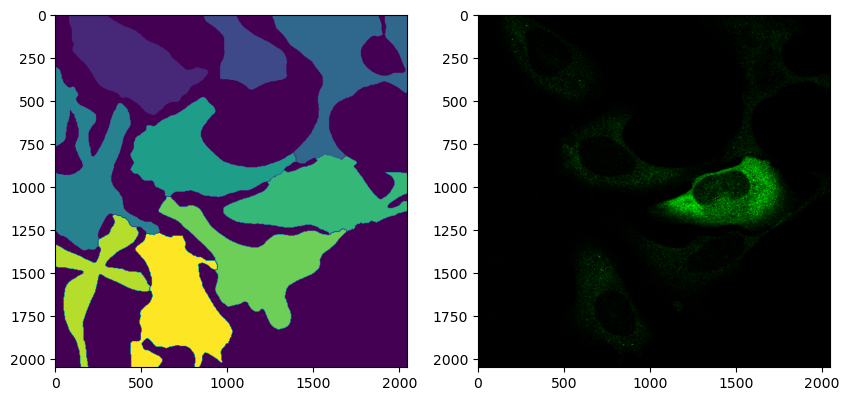

<Figure size 640x480 with 0 Axes>

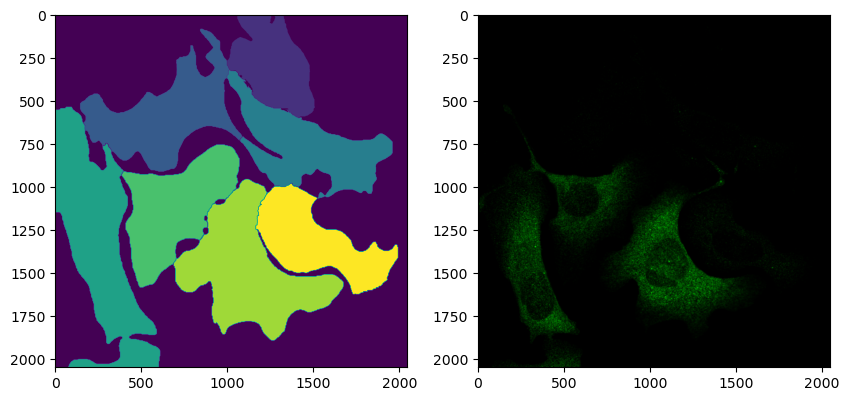

<Figure size 640x480 with 0 Axes>

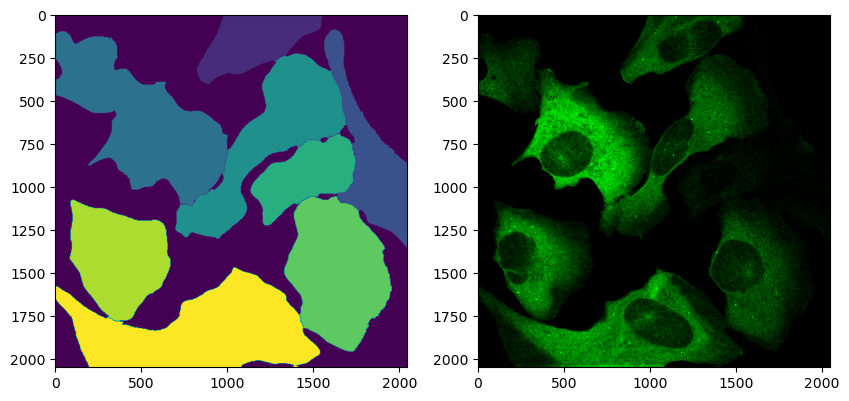

<Figure size 640x480 with 0 Axes>

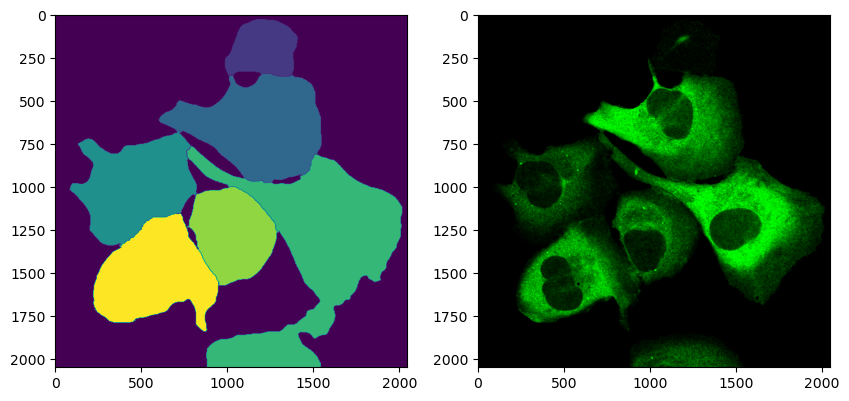

<Figure size 640x480 with 0 Axes>

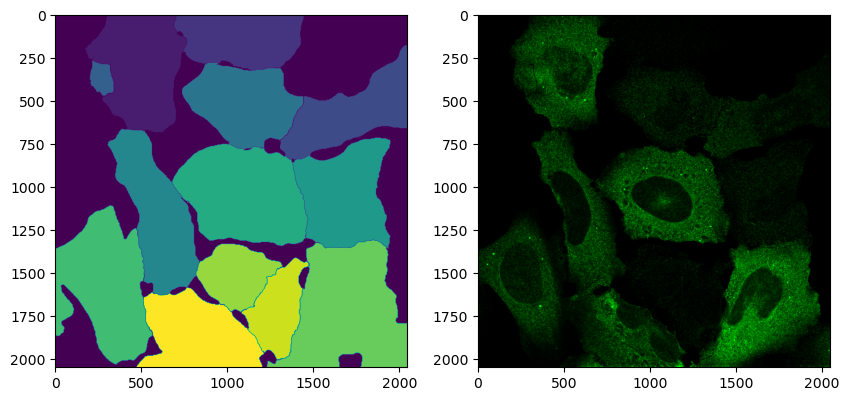

<Figure size 640x480 with 0 Axes>

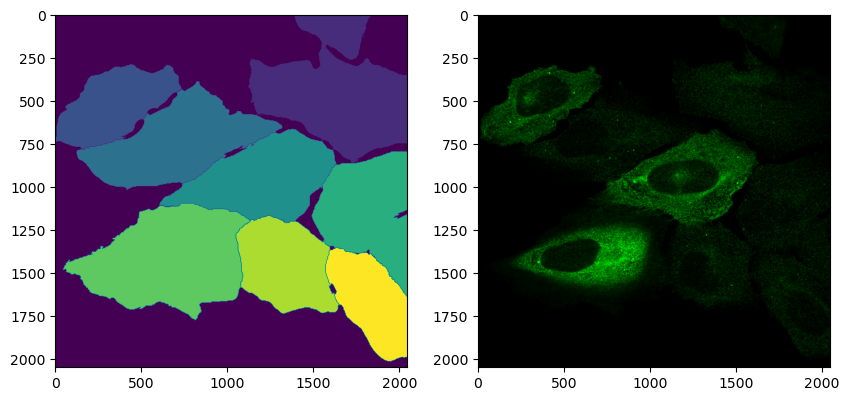

In [7]:
# prep data needed for model inference and visualization

image_paths = []
cell_mask_paths = []
for well in prot_well_names:
    # should really get these from the dataset config
    image_paths.append(DS_HOME / well / f"imagesmin_max.npy")
    cell_mask_paths.append(DS_HOME / well / f"cell_masks_no_border_rm_1000_sharp_none.npy")
    # cell_mask_paths.append(DS_HOME / well / f"cell_masks_no_border_rm_1000_sharp_1250.npy")

images = np.concatenate([np.load(p) for p in image_paths])

masks = [np.load(p) for p in cell_mask_paths]
n_per_well = [len(m) for m in masks]
masks = np.concatenate(masks)

ref_images = images[:, :2, ...]
# color_images = [save_image(torch.Tensor(I[[0, 1, 3]]), HOME / "temp.png", cmaps=["pure_blue", "pure_red", "pure_green"]) for I in images]
color_images = [save_image(torch.Tensor(I[[3]]), HOME / "temp.png", cmaps=["pure_green"]) for I in images]
# color_images = [save_image(torch.Tensor(I), HOME / "temp.png", cmaps=["pure_blue", "pure_yellow", "pure_green", "pure_red"]) for I in images]
# target_images = [save_image(torch.Tensor(I[[2, 3]]), HOME / "temp.png", cmaps=["pure_green", "pure_red"]) for I in images]

for i in range(len(color_images)):
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(masks[i])
    ax[1].imshow(color_images[i])
    plt.show()

sc_images = torch.concat([torch.load(DS_HOME / well / "images_minimal.pt") for well in prot_well_names])
assert len(sc_images) == sum([len(np.unique(m)) - 1 for m in masks])

In [8]:
# get well percentiles
percentiles = np.linspace(0, 100, buckets)
# n, j, k = 0, 0, 0
j, k = 0, 0
well_intensities = []
n_cells_per_well = []
for i in range(len(n_per_well)):
    k = j + n_per_well[i]
    well_images = ref_images[j:k]
    well_int_levels, _ = get_batch_percentiles(well_images, percentiles)
    well_int_levels = np.concatenate(well_int_levels)
    n_cells = sum([len(np.unique(m)) - 1 for m in masks[j:k]])
    n_cells_per_well.append(n_cells)
    well_intensities.append(np.tile(well_int_levels, (n_cells, 1)))
    j = k
well_intensities = torch.Tensor(np.concatenate(well_intensities))
print(well_intensities.shape)

torch.Size([51, 512])


In [9]:
from HPA_CC.models.dino import DINO_HPA
from torch.utils.data import DataLoader
from HPA_CC.data.dataset import SimpleDataset


device = "cuda:0"
DINO_CONFIG = HOME / "configs" / "dino_config.yaml"
dino = DINO_HPA(DINO_CONFIG, device=device)
dataset = SimpleDataset(tensor=sc_images[:, :2, ...])
dataloader = DataLoader(dataset, batch_size=32, num_workers=1, shuffle=False)
embeddings = []
with torch.no_grad():
    for batch in iter(dataloader):
        batch = batch.to(device)
        batch_embedding = dino.predict_cls_ref_concat(batch).cpu()
        embeddings.append(batch_embedding)
embeddings = torch.cat(embeddings)
print(embeddings.shape)

config['model']['arch'] vit_base in vits
loaded /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth
Pretrained weights found at /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181081/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([51, 1536])


# Model Inference

In [10]:
log_dirs_home = Path("/data/ishang/pseudotime_pred/")
device = "cuda:0"

In [11]:
model_name = "HPA DINO Classifier"
# model_hash = "1gu6u2qu" # int focal scope
# model_hash = "ee9r9c1l" # int soft focal
# model_hash = "sltskj1m" # soft focal scope
model_hash = "2osnjoe7" # focal scope
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = False # were intensity statistics added to the embedding? (not used from conv)
label_type = "phase" # "phase", "angle", or "pseudotime"
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
phase_model = ClassifierLit.load_from_checkpoint(checkpoint_file)
phase_model.to(device)
phase_model.eval()
input = torch.concat([embeddings, well_intensities], dim=1) if int_stats else embeddings
prot_phase_dataset = SimpleDataset(tensor=input)

RuntimeError: Error(s) in loading state_dict for ClassifierLit:
	Missing key(s) in state_dict: "model.model.0.weight", "model.model.0.bias", "model.model.2.weight", "model.model.2.bias". 
	Unexpected key(s) in state_dict: "model._orig_mod.model.0.weight", "model._orig_mod.model.0.bias", "model._orig_mod.model.2.weight", "model._orig_mod.model.2.bias". 

In [ ]:
model_name = "HPA DINO Pseudotime Regressor"
# model_hash = "81peszw2" # no int
model_hash = "vh4v2w5d" # int
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = True # were intensity statistics added to the embedding? (not used from conv)
label_type = "pseudotime" # "phase", "angle", or "pseudotime"
scope = None
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
pseudo_model = PseudoRegressorLit.load_from_checkpoint(checkpoint_file)
pseudo_model.to(device)
pseudo_model.eval()
input = torch.concat([embeddings, well_intensities], dim=1) if int_stats else embeddings
prot_pseudo_dataset = SimpleDataset(tensor=input)

In [ ]:
pseudo_preds = regressor_inference(pseudo_model, DataLoader(prot_pseudo_dataset, batch_size=32, num_workers=1, shuffle=False), device)
phase_preds = classifier_inference(phase_model, DataLoader(prot_phase_dataset, batch_size=32, num_workers=1, shuffle=False), device)
print(pseudo_preds.shape, phase_preds.shape)

(51,) (51,)


In [76]:
model_name = "HPA DINO Multi-model"
# model_hash = "s41dnlu2" # soft without dropout
# model_hash = "w4zfasnx" # hard with dropout
# model_hash = "rvvae90k" # hard with dropout, using image-level intensities, lol this one is ass
# model_hash = "zb99ws39" # without intensities
# model_hash = "llfsg1tc" # without intensities
model_hash = "xhnjriuf" # chamber only
# model_hash = "ya6stucp" # overview only
# model_hash = "lv2xkqjm" # tilescan only
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = False # were intensity statistics added to the embedding? (not used from conv)
label_type = "pseudotime" # "phase", "angle", or "pseudotime"
scope = True
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=False)
combined_model = CombinedModelLit.load_from_checkpoint(checkpoint_file)
combined_model.to(device)
combined_model.eval()
input = torch.concat([embeddings, well_intensities], dim=1) if int_stats else embeddings
prot_pseudo_dataset = SimpleDataset(tensor=input)
pseudo_preds, angle_preds, phase_preds = combined_inference(combined_model, DataLoader(prot_pseudo_dataset, batch_size=32, num_workers=1, shuffle=False), device)
# pseudo_preds = stretch_time(angle_preds)

# Annotated Images

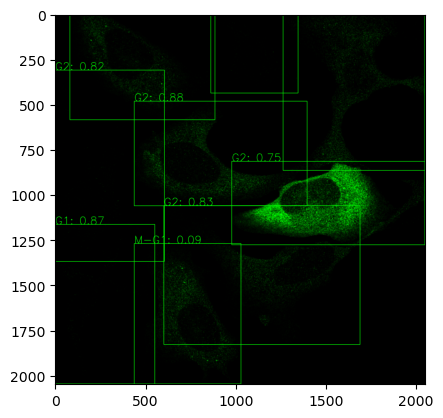

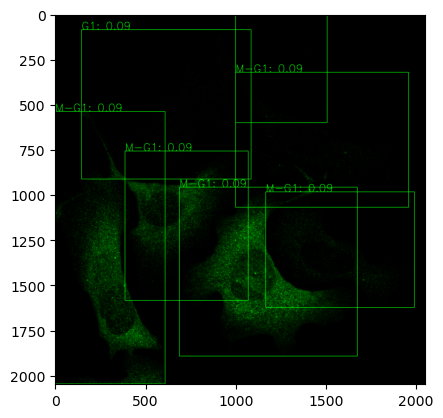

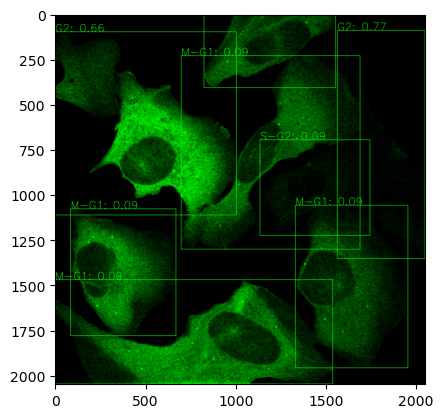

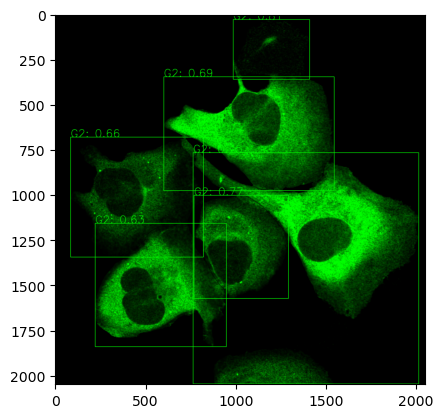

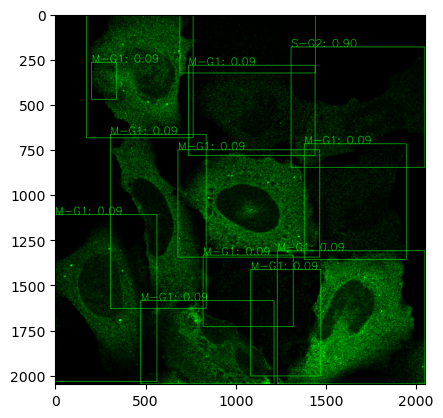

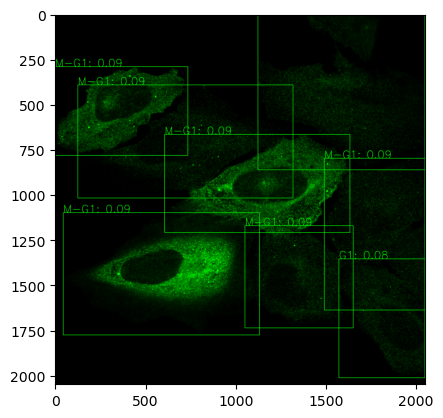

In [77]:
cell_idx = 0
for image, mask in zip(color_images, masks):
# for image, mask in zip(target_images, masks):
    n_cells = len(np.unique(mask)) - 1
    pseudotimes = pseudo_preds[cell_idx:cell_idx + n_cells]
    phases = phase_preds[cell_idx:cell_idx + n_cells]
    pseudotimes = np.round(pseudotimes, 2)
    phases = [classes[p] for p in phases]
    image = np.array(image)
    annotated_image = annotate_cell_image(image, mask, pseudotimes, phases)
    cell_idx += n_cells
    plt.clf()
    plt.imshow(annotated_image)
    plt.show()

# HPA Prediction Histograms

In [78]:
HPA_dm = RefCLSDM(HPA_DS_PATH, data_name, 32, 1, "all", inference=True, concat_well_stats=int_stats)
FUCCI_dm = RefCLSDM(FUCCI_DS_PATH, data_name, 32, 1, "all", inference=True, concat_well_stats=int_stats)
h_pseudo_preds, h_angle_preds, h_phase_preds = combined_inference(combined_model, HPA_dm.inference_dataloader(), device)
f_pseudo_preds, f_angle_preds, f_phase_preds = combined_inference(combined_model, FUCCI_dm.inference_dataloader(), device)

Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
X shape: torch.Size([1870, 1536])
Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
X shape: torch.Size([31737, 1536])


In [79]:
HPA_dm = RefCLSDM(HPA_DS_PATH, data_name, 32, 1, "all", inference=True, concat_well_stats=True)
FUCCI_dm = RefCLSDM(FUCCI_DS_PATH, data_name, 32, 1, "all", inference=True, concat_well_stats=True)
datamodule = HPA_dm
preds = h_pseudo_preds
well_labels = np.zeros_like(preds)
well_label = 0
curr_well = datamodule.dataset.X[0][1536:]
print(curr_well)
for i in range(len(well_labels)):
    if not np.equal(datamodule.dataset.X[i][1536:], curr_well).all():
        well_label += 1
        curr_well = datamodule.dataset.X[i][1536:]
    well_labels[i] = well_label
print(len(np.unique(well_labels)))

Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/all_HPA-CC-dataset/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([1870, 1536])
X shape: torch.Size([1870, 2048])
Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([31737, 1536])
X shape: torch.Size([31737, 2048])
tensor([1.5259e-05, 1.6785e-04, 3.2044e-04, 4.7304e-04, 6.2563e-04, 7.9348e-04,
        9.6133e-04, 1.1292e-03, 1.3123e-03, 1.4801e-03, 1.6633e-03, 1.8464e-03,
        2.0447e-03, 2.2279e-03, 2.4110e-03, 2.6093e-03, 2.7924e-03, 2.9908e-03,
        3.2044e-03, 3.3876e-03, 3.6012e-03, 3.8148e-03, 4.0132e-03, 4.2268e-03,
        4.4404e-03, 4.6693e-03, 4.8830e-03, 5.1119e-03, 5.3407e-03, 5.5696e-03,
        5.8138e-03, 6.0427e-03, 6.2868e-03, 6.5310e-03, 6.7751e-03, 7.0345e-03,
        7.2787e-03, 7.5381e-03, 7.8127e-03, 

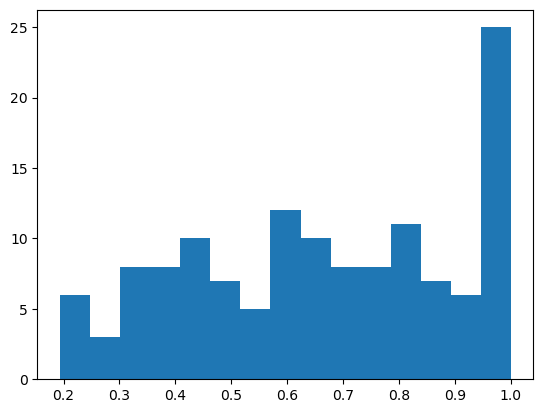

In [80]:
def angular_distance(x, y):
    return min(np.abs(x - y), 2 * np.pi - np.abs(x - y))

# get the spread in pseudotime predictions for each well
well_pseudo_pred_spreads = []
for i in range(len(np.unique(well_labels))):
    well_pseudo_preds = preds[well_labels == i]
    angular_distances = []
    for i in range(len(well_pseudo_preds)):
        for j in range(i+1, len(well_pseudo_preds)):
            distance = angular_distance(well_pseudo_preds[i], well_pseudo_preds[j])
            angular_distances.append(distance)
    angular_distances = np.array(angular_distances)
    # well_pseudo_pred_spreads.append(np.std(angular_distances))
    well_pseudo_pred_spreads.append(np.sum(angular_distances < 0.1) / len(angular_distances))
    
plt.clf()
plt.hist(well_pseudo_pred_spreads, bins=15)
plt.show()

[0.56569104 0.27307252 0.08581989 0.02283875 0.02103309] 0.8387635569987859


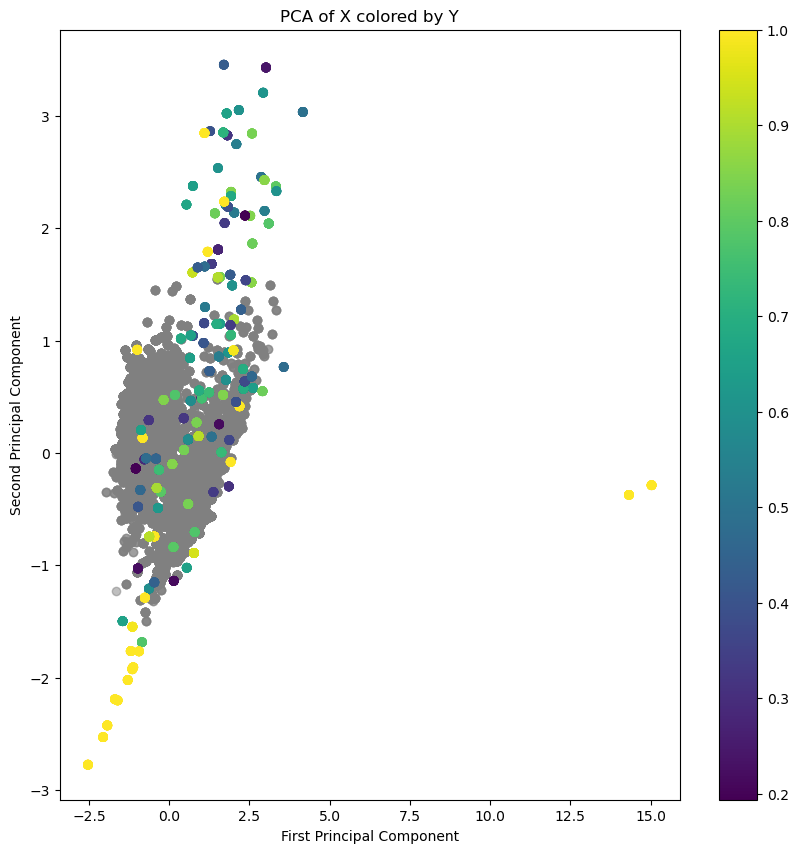

In [81]:
X = torch.concat([HPA_dm.dataset.X, FUCCI_dm.dataset.X], dim=0)
Y = np.zeros((len(X),))
for i in range(len(np.unique(well_labels))):
    well_idx = np.where(well_labels == i)[0]
    Y[well_idx] = well_pseudo_pred_spreads[i]


# Perform PCA on X
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X[:, 1536:])
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_[:2]))
# Create a scatter plot of the first two principal components
# fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
# axes[1].scatter(X_pca[len(h_pseudo_preds):, 0], X_pca[len(h_pseudo_preds):, 1], c=Y[len(h_pseudo_preds):], cmap='viridis', alpha=0.5)
# sc = axes[0].scatter(X_pca[:len(h_pseudo_preds), 0], X_pca[:len(h_pseudo_preds), 1], c=Y[:len(h_pseudo_preds)], cmap='viridis', alpha=0.5)
fig = plt.figure(figsize=(10, 10))
plt.scatter(X_pca[len(h_pseudo_preds):, 1], X_pca[len(h_pseudo_preds):, 2], color='gray', alpha=0.5)
sc = plt.scatter(X_pca[:len(h_pseudo_preds), 1], X_pca[:len(h_pseudo_preds), 2], c=Y[:len(h_pseudo_preds)], cmap='viridis')
plt.colorbar(sc)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of X colored by Y')
plt.show()


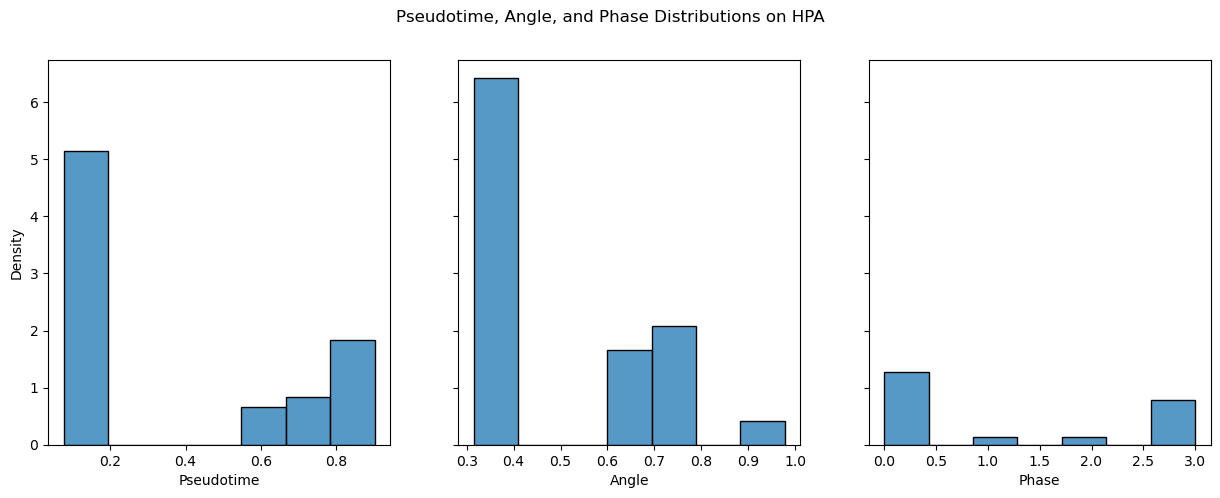

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.histplot(pseudo_preds, ax=ax[0], stat="density")
sns.histplot(angle_preds, ax=ax[1], stat="density")
sns.histplot(phase_preds, ax=ax[2], stat="density")
ax[0].set_xlabel("Pseudotime")
ax[1].set_xlabel("Angle")
ax[2].set_xlabel("Phase")
plt.ylabel("Density")
fig.suptitle("Pseudotime, Angle, and Phase Distributions on HPA")
plt.show()